# Necessary Libraries & Global Variables

In [5]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as ss
import pandas as pd
import warnings
import random
import logging

import time
import pdb

#SMALL_VAL = 0.0000001
SMALL_VAL = 1
Zero = 0
RAND_COUNT = 10000
group_id_cnt = 0

# Maximum Likelihood Estimation
The following methods calculate MLE of different distributions based on the input empirical data

MLE calculator returns at most 4 parameters for the distributions "normal", "log-normal", "power law", "fisk", "binomial", "zero-inflated log-normal", and "zero-inflated power law".
1. locale -> key: loc
2. scale -> key: scale
3. shape -> key: shape

input zero shows the real number that should be considered as zero if the data is normalized into 0.005 to 1 of range of x.

NOTE: WHEN N, COUNT OF DATA TO CALCULATE MLE, AND N', COUNT OF OUT-OF-SAMPLE DATA TO CALCULATE LIKELIHOOD ON ARE NOT EQUAL, VALUE OF ZERO IS NOT THE SAME. DON'T KNOW WHAT WE SHOULD DO IN THIS CASE!!!

In [132]:
def mle(data, dist, zero = 0):
    loc = -1
    scale = -1
    shape = -1
    p0 = -1 # Probability of being zero in zero-inflated distributions
    
    warningMsg = "Data out of range for " + dist + ". Will remove "
    #logging.warn(warningMsg.format("x<=0"))
    if dist == 'norm': # MLE for Normal
        loc = np.mean(data)
        scale = np.std(data)
    
    if dist == 'lognorm': # MLE for Log-normal
        if min(data) <= 0:
            logging.warn(warningMsg+"x <= 0")
        data = data[data > 0]
        lndata = np.log(data)
        loc = np.mean(lndata)
        scale = np.std(data)
    
    if dist == 'powerlaw': # MLE for Power Law
        if min(data) <= 0:
            logging.warn(warningMsg+"x <= 0")
        # x_min is just set to the smallest non-zero x
        data = data[data > 0]
        x_min = min(data)
        shape = 1 + len(data)/(np.sum(np.log(data/x_min)))
    
    if dist == 'zin_lognorm': # MLE for Zero-Inflated Log-normal
        if min(data) < 0:
            logging.warn(warningMsg+"x < 0")
        data = data[data >= zero]
        p0 = len(data[data == zero])/len(data)
        data = data[data > zero]
        # log-normal MLE
        lndata = np.log(data)
        loc = np.mean(lndata)
        scale = np.std(data)
        
    if dist == 'zin_powerlaw': # MLE for Zero-Inflated Power Law
        if min(data) < 0:
            logging.warn(warningMsg+"x < 0")
        data = data[data >= zero]
        p0 = len(data[data == zero])/len(data)
        # power law MLE
        data = data[data > zero]
        x_min = min(data)
        shape = 1 + len(data)/(np.sum(np.log(data/x_min)))

    if dist == 'binomial' or dist == 'bernoulli': # MLE for Binomial or Bernoulli
        if not all(item.is_integer() for item in data):
            logging.warn("Can't calculate MLE. Not integer values for Binomial distribution.")
        else:
            if min(data) < zero:
                logging.warn(wanringMsg.format("x < " + str(zero)))
        data = data[data >= zero]
        p0 = len(data[data == zero])/len(data)
        
    return {'loc':loc, 'scale':scale, 'shape':shape, 'p0':p0}

# pdf or pmf 
Results of out-of-sample data based for the theoretical distribution given its parameters.

In [117]:
def pdmf(data, dist, params, zero = 0):

    loc = params['loc']
    scale = params['scale']
    shape = params['shape']
    p0 = params['p0']
    
    ll = None
    warningMsg = "Data out of range for " + dist + ". Will remove "
    
    if dist == 'norm': # pdf for Normal
        pdmf_arr = np.exp(-(data-loc)**2/(2*scale**2))/(scale * np.sqrt(2*np.pi))

    if dist == 'lognorm': # pdf for Log-normal
        if min(data) <= 0:
            logging.warn(warningMsg+"x <= 0")
        data = data[data > 0]
        lndata = np.log(data)
        pdmf_arr = np.exp(-(lndata-loc)**2/(2*scale**2))/(data*scale*np.sqrt(2*np.pi))
    
    if dist == 'powerlaw': # pdf for Power Law
        if min(data) <= 0:
            logging.warn(warningMsg+"x <= 0")
        # x_min is just set to the smallest non-zero x
        data = data[data > 0]
        x_min = min(data)
        pdmf_arr = (shape-1)*(data/x_min)**(-shape)/x_min
    
    if dist == 'zin_lognorm': # pmf for Zero-Inflated Log-normal
        if min(data) < 0:
            logging.warn(warningMsg+"x < 0")
        zero_count = len(data[data == zero])
        data = data[data > zero] # nonzero data
        lndata = np.log(data)
        pdmf_arr = -np.exp((lndata-loc)**2/(2*scale**2))/(data*scale*np.sqrt(2*np.pi))
        pdmf_arr = np.append((1 - p0)*pdmf_arr, [p0]*zero_count)
        
    if dist == 'zin_powerlaw': # pmf for Zero-Inflated Power Law
        if min(data) < 0:
            logging.warn(warningMsg+"x < 0")
        data = data[data >= zero]
        zero_count = len(data[data == zero])
        data = data[data > zero]
        x_min = min(data)
        pdmf_arr = (shape-1)*(data/x_min)**(-shape)/x_min
        pdmf_arr = np.append((1 - p0)*pdmf_arr, [p0]*zero_count)
        
    if dist == 'binomial': # pmf for Binomial
        if not all(item.is_integer() for item in data):
            logging.warn("Can't calculate MLE. Not integer values for Binomial distribution.")
        else:
            if min(data) < 0:
                logging.warn(wanringMsg+"x < 0")
            #TODO, NOT IMPLEMENTED YET
            
    if dist == 'bernoulli': # pmf for Bernoulli
        if not all(item.is_integer() for item in data):
            logging.warn("Can't calculate MLE. Not integer values for Bernoulli distribution.")
        else:
            if min(data) < 0:
                logging.warn(wanringMsg+"x < 0")
            #TODO, NOT IMPLEMENTED YET        
    return pdmf_arr

def llhood(data, dist, params, zero = 0):
    pdmf_arr = pdmf(data, dist, params, zero)
    ll = np.sum(np.log(pdmf_arr))    
    return ll


# Find Best Fit Distribution
## Function name: best_fit_distribution
**Args:**
* data -> a series of data values (like group norms in our case)
* bins -> how many bins we want to divide the data into (default = 200)
* ax -> axes subplots (default None)
  * subplot of the data with x and y limits set
  * If given, this function will add histogram of data + all different distribution lines to this subplot

**Returns:**
* Best_Distribution_name -> winner among all distributions
* Best_SSE -> Minimum sum of squared error
* Best_params -> parameters of the best distribution which has at least two parameters of "Location" and "Scale" + any additional parameters based on the distribution type

**What it does?**
* Creates a histogram of the data divided to <BINS> bins
* Sets x as the center of each bin
* Sets y as the frequency value of each bin (normed = True)
* Finds the best fit distribution among previously defined distributions based on the SSE of the returned value and the actual value
  * Uses scipy.stats distribution methods **fit** and **pdf**
  * scipy.stats current Distributions are **norm**, **expon**, and **lognorm** for now
* If ax is set, it adds histogram and all the distributions lines with their MLE parameters to that

In [23]:
# Create models from data
def best_fit_distribution(input_data, ax=None, plot_pdf = False, test_significance=True):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        'norm', 'lognorm', 'powerlaw', 'zin_lognorm', 'zin_powerlaw'
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_ll = -1 * np.inf

    dist_ll = {}

    N = len(input_data)
    random.shuffle(input_data)
    train_end = int(N/2)
    data = np.sort(input_data[0:train_end])
    test = np.sort(input_data[train_end:N])
    #data = np.sort(input_data)
    #test = np.sort(input_data)
    input_data = np.sort(input_data)
    
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            params = mle(data, distribution)
            ll = loglikelihood(data, distribution)

            dist_ll[distribution.name] = [round(ll, 2), params]
            # if axis pass in add to plot
            try:
                if ax:
                    # Calculate fitted PDF and error with fit in distribution
                    if plot_pdf:
                        y = distribution.pdf(input_data, loc=params[-2], scale=params[-1], *params[:-2])
                    else:
                        y = distribution.cdf(input_data, loc=params[-2], scale=params[-1], *params[:-2])
                    pd.Series(y, input_data). \
                    plot(ax=ax, label=distribution.name + str(round(ll, 2)))
            except Exception as detail:
                print('Plotting Runtime Error: ' + str(detail))
                pass
            # identify if this distribution is better
            if best_ll < ll:
                best_distribution = distribution
                best_params = params
                best_ll = ll
        except Exception as detail:
            print('Runtime Error: ' + str(detail))
            pass
            
    return (best_distribution.name, best_ll, best_params, dist_ll)

Test

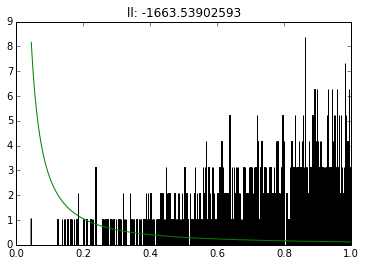

In [141]:
data = ss.powerlaw.rvs(3,size=1000)
data = np.sort(data)
#data = data + [0] * 100
val_idx = plt.hist(data, bins=1000, normed=1)
idx = val_idx[1]
params = mle(data, 'powerlaw', 0)
params2 = ss.powerlaw.fit(data)
ll = llhood(data, 'powerlaw', params, 0)
idx = (idx[1:] + idx[:-1])/2
pdmf_arr = pdmf(idx, 'powerlaw', params, 0)
pdf = ss.powerlaw.pdf(idx, loc=params2[-2], scale=params2[-1], *params2[:-2])
#pdb.set_trace()
plt.plot(idx, pdmf_arr)
plt.title('ll: ' + str(ll))